In [1]:
import numpy as np
import numpy as np
import random

In [2]:
class World:
    """
    The World class encapsulates information about the computational domain.
    
    Attributes
    ----------
    
    ----------
    
    """
    
    def __init__(self, ni, nj, nk):
        """
        Initializes the planet object with the planetary constants.

        Parameters
        ----------
        ni : int
            number of grid points along x coordinate
        nj : int
            number of grid points along y coordinate
        nk : int
            number of grid points along z coordinate
        ----------
        
        """
        
        self.ni = ni
        self.nj = nj
        self.nk = nk
        
        self.nn = np.zeros(3)
        
        self.nn[0] = self.ni
        self.nn[1] = self.nj
        self.nn[2] = self.nk
        
        self.x0 = np.zeros(3)
        self.dh = np.zeros(3)
        self.xm = np.zeros(3)
        self.xc = np.zeros(3)
        
        self.EPS_0 = 8.85418782e-12
        self.QE    = 1.602176565e-19;
        self.AMU   = 1.660538921e-27
        self.ME    = 9.10938215e-31;
        self.K     = 1.380648e-23;
        self.EvToK = self.QE/self.K;
        
        self.phi        = np.zeros((self.ni, self.nj, self.nk))
        self.rho        = np.zeros((self.ni, self.nj, self.nk))
        self.node_vol   = np.zeros((self.ni, self.nj, self.nk))
        self.ef         = np.zeros((self.ni, self.nj, self.nk, 3))
    
    def setTime(self, dt, num_ts):
        self.dt     = dt
        self.num_ts = num_ts
        
    def setExtents(self, x1, y1, z1, x2, y2, z2):
        
        """
        Set mesh extents and compute grid spacing.

        Parameters
        ----------
        x1 : float
            x-coordinate of world origin
        y1 : float
            y-coordinate of world origin
        z1 : float
            z-coordinate of world origin
        x2 : float
            x-coordinate of world max bound
        y2 : float
            y-coordinate of world max bound
        z2 : float
            z-coordinate of world max bound
        ----------
        
        """
        
        self.x0[0] = x1
        self.x0[1] = y1
        self.x0[2] = z1
        
        self.xm[0] = x2
        self.xm[1] = y2
        self.xm[2] = z2
        
        for i in range(3):
            self.dh[i] = (self.xm[i] - self.x0[i]) / (self.nn[i] - 1)
            self.xc[i] = 0.5*(self.x0[i] + self.xm[i]) 
        
        self.computeNodeVolumes()
    
    def computeDebyeLength(self, Te, ne):
        """
        Compute the Debye length.

        Parameters
        ----------
        Te : float
            electron temperature, K
        ne : float
            number density, m3
        ----------
        
        """
        
        return np.sqrt(self.EPS_0*self.K*Te/(ne*self.QE**2))
    
    
    def potentialSolver(self, max_it, tol):
        """
        Compute the potential field.

        Parameters
        ----------
        max_it : int
            max iterations for Gauss-Seidel
        tol: float
            tolerance for Gauss-Seidel
        ----------
        
        """

        dx2 = 1.0/(self.dh[0]*self.dh[0]); # dx^2
        dy2 = 1.0/(self.dh[1]*self.dh[1]); # dy^2
        dz2 = 1.0/(self.dh[2]*self.dh[2]); # dz^2
    
        L2 = 0.0 # norm
        
        converged = False
        
        # solve potential
        for it in np.arange(1,max_it+1):
            for i in np.arange(1,self.ni-1):
                for j in np.arange(1,self.nj-1):
                    for k in np.arange(1,self.nk-1):
                        #standard internal open node
                        phi_new = (self.rho[i][j][k]/self.EPS_0 +\
                                        dx2*(self.phi[i-1][j][k] + self.phi[i+1][j][k]) +\
                                        dy2*(self.phi[i][j-1][k] + self.phi[i][j+1][k]) +\
                                        dz2*(self.phi[i][j][k-1] + self.phi[i][j][k+1]))/(2*dx2+2*dy2+2*dz2)
                        
                        # sucessive over relaxation  
                        self.phi[i,j,k] = self.phi[i,j,k] + 1.4*(phi_new - self.phi[i][j][k])
        

            #check for convergence*/
            if it%25==0:
                sum = 0;
                for i in np.arange(1,self.ni-1):
                    for j in np.arange(1,self.nj-1):
                        for k in np.arange(1,self.nk-1):

                            R = -self.phi[i][j][k]*(2*dx2+2*dy2+2*dz2) +\
                            self.rho[i][j][k]/self.EPS_0 +\
                            dx2*(self.phi[i-1][j][k] + self.phi[i+1][j][k]) +\
                            dy2*(self.phi[i][j-1][k] + self.phi[i][j+1][k]) +\
                            dz2*(self.phi[i][j][k-1] + self.phi[i][j][k+1])

                            sum += R*R;


                L2 = np.sqrt(sum/(self.ni*self.nj*self.nk));
                #print("iter: "+str(it)+", L2 = "+str(L2))
                if (L2<tol):
                    converged = True
                    break
                    
        if (converged==False):
            print("Gauss-Seidel failed to converge, L2 = "+str(L2))
        
        return converged
    
    def efSolver(self):
        """
        Compute the electric field from potential function.

        Parameters
        ----------
        
        ----------
        
        """
        dx = self.dh[0] # dx
        dy = self.dh[1] # dy
        dz = self.dh[2] # dz
        
        for i in np.arange(0, self.ni):
            for j in np.arange(0, self.nj):
                for k in np.arange(0, self.nk):

                    #x-component#
                    if i==0: 
                        # forward
                        self.ef[i][j][k][0] = -(-3*self.phi[i][j][k]+\
                                               4*self.phi[i+1][j][k]-\
                                               self.phi[i+2][j][k])/(2*dx)
                    elif i==self.ni-1:  
                        # backward
                        self.ef[i][j][k][0] = -(self.phi[i-2][j][k]-\
                                               4*self.phi[i-1][j][k]+\
                                               3*self.phi[i][j][k])/(2*dx)
                    else: 
                        #central
                        self.ef[i][j][k][0] = -(self.phi[i+1][j][k] - \
                                                self.phi[i-1][j][k])/(2*dx)

                    #y-component
                    if j==0:
                        self.ef[i][j][k][1] = -(-3*self.phi[i][j][k] + \
                                                4*self.phi[i][j+1][k]-\
                                                self.phi[i][j+2][k])/(2*dy)
                    elif j==self.nj-1:
                        self.ef[i][j][k][1] = -(self.phi[i][j-2][k] - \
                                                4*self.phi[i][j-1][k] +\
                                                3*self.phi[i][j][k])/(2*dy)
                    else:
                         self.ef[i][j][k][1] = -(self.phi[i][j+1][k] - \
                                                 self.phi[i][j-1][k])/(2*dy)

                    #z-component
                    if k==0:
                        self.ef[i][j][k][2] = -(-3*self.phi[i][j][k] + \
                                                4*self.phi[i][j][k+1]-
                                                self.phi[i][j][k+2])/(2*dz)
                    elif k==self.nk-1:
                        self.ef[i][j][k][2] = -(self.phi[i][j][k-2] - \
                                                4*self.phi[i][j][k-1]    + \
                                                3*self.phi[i][j][k])/(2*dz)
                    else:
                        self.ef[i][j][k][2] = -(self.phi[i][j][k+1] - \
                                                self.phi[i][j][k-1])/(2*dz)
                        
    def computeNodeVolumes(self): 
        """
        Compute the node volumes.
        Parameters
        ----------
        
        ----------
        
        """
        for i in np.arange(0,self.ni):
            for j in np.arange(0,self.nj):
                for k in np.arange(0,self.nk):
        
                    V = self.dh[0]*self.dh[1]*self.dh[2]
                    if (i==0 or i==self.ni-1): V*=0.5
                    if (j==0 or j==self.nj-1): V*=0.5
                    if (k==0 or k==self.nk-1): V*=0.5
                    
                    self.node_vol[i][j][k] = V
                    
    def XtoL(self, x):
        """
        Determine which cell a particle at position vector 
        x belongs to.
        
        Parameters
        ----------
        x : numpy.ndarray
            position vector 
        ----------
        """
        lc = np.zeros(3)
        
        lc[0] = (x[0]-self.x0[0])/self.dh[0];
        lc[1] = (x[1]-self.x0[1])/self.dh[1];
        lc[2] = (x[2]-self.x0[2])/self.dh[2];
        
        return lc
    
    def addSpeciesList(self, speciesList):
        self.speciesList = speciesList
    
    def computeChargeDensity(self):
        """
        Compute the charge density.
        
        Parameters
        ----------
     
        ----------
        """
        
        self.rho = np.zeros((self.ni, self.nj, self.nk))
        
        for species in self.speciesList:
            if species.charge!=0:
                self.rho += species.charge*species.den         

In [3]:
class Particle:
    """
    The Particle class encapsulates information about the particles 
    used in the simulation.
    
    Attributes
    ----------
    
    ----------
    
    """
    
    def __init__(self, pos, vel, mpw):
        """
        Initializes the Particle object with the position, 
        speed, and macrparticle weight.

        Parameters
        ----------
        pos : numpy.ndarray
            particle position vector
        vel : numpy.ndarray
            particle velocity vector
        mpw : float
            macroparticle weight  
        ----------
        
        """
        
        self.pos = pos
        self.vel = vel
        self.mpw = mpw
        

class Species:
    """
    The Species class encapsulates information about the species 
    used in the simulation.
    
    Attributes
    ----------
    
    ----------
    
    """
    def __init__(self, name, mass, charge, worldObj):
        """
        Initializes the Species object with the name, mass,
        charge.

        Parameters
        ----------
        name : str
            species name
        mass : float
            species mass
        charge : float
            species charge
        mpw : float
            macroparticle weight  
        ----------

        """
        
        self.particleList = []
        
        self.name   = name
        self.mass   = mass
        self.charge = charge
        
        self.den    = np.zeros((worldObj.ni, worldObj.nj, worldObj.nk))
        
        self.worldObj = worldObj
    
    def addParticle(self, pos, vel, mpw):
        """random.random()
        add a particle to particleList

         Parameters
        ----------
        pos : numpy.ndarray
            particle position vector
        vel : numpy.ndarray
            particle velocity vector
        mpw : float
            macroparticle weight  
        ----------
        
        """
        #get logical coordinate of particle's position
        lc = self.worldObj.XtoL(pos)

        #electric field at particle position
        ef_part = self.gather_ef(lc)

        #rewind velocity back by 0.5*dt*ef
        vel -=  self.charge/self.mass*ef_part*(0.5*self.worldObj.dt);
        
        #add particle to list
        self.particleList.append(Particle(pos, vel, mpw))
        
        
    def loadParticlesBox(self, x1, x2, num_den, num_mp):
        """
        loads randomly distributed particles in a x1-x2 box 
        representing num_den number density

        Parameters
        ----------
        x1 : numpy.ndarray
            origin of bounding box
        x2 : numpy.ndarray
            max. bound corner of box
        num_den : float
            number density
        num_mp  : number of macroparticles
        ----------

        """
        box_vol  = (x2[0]-x1[0])*(x2[1]-x1[1])*(x2[2]-x1[2]) # box vol.
        num_real = num_den * box_vol;                   #number of real particles
        mpw      = num_real/num_mp;                     # macroparticle weight
        
        self.box_vol = box_vol
        self.num_real= num_real
        self.mpw     = mpw

        #load particles on an equally spaced grid
        for p in np.arange(0,num_mp+1):
            # sample random position
            pos = np.zeros(3)
            vel = np.zeros(3)

            #rnd = random.random()

            pos[0] = x1[0] + random.random()*(x2[0]-x1[0]);
            pos[1] = x1[1] + random.random()*(x2[1]-x1[1]);
            pos[2] = x1[2] + random.random()*(x2[2]-x1[2]);

            #set initial velocity
            vel[0] = 0.0
            vel[1] = 0.0
            vel[2] = 0.0

            self.addParticle(pos,vel,mpw); # add new particle
            
    def loadParticlesBoxQS(self, x1, x2, num_den, num_mp):
        """
        loads randomly distributed particles in a x1-x2 box 
        representing num_den number density

        Parameters
        ----------
        x1 : numpy.ndarray
            origin of bounding box
        x2 : numpy.ndarray
            max. bound corner of box
        num_den : float
            number density
        num_mp  : numpy.ndarray
        ----------

        """
        box_vol  = (x2[0]-x1[0])*(x2[1]-x1[1])*(x2[2]-x1[2]) # box vol.
        num_real = num_den * box_vol;                   #number of real particles
        num_mp_tot = (num_mp[0]-1)*(num_mp[1]-1)*(num_mp[2]-1)
        mpw      = num_real/num_mp_tot;                     # macroparticle weight
        
        self.box_vol = box_vol
        self.num_real= num_real
        self.mpw     = mpw
        
        di = (x2[0]-x1[0])/(num_mp[0]-1);
        dj = (x2[1]-x1[1])/(num_mp[1]-1);
        dk = (x2[2]-x1[2])/(num_mp[2]-1);

        #load particles on a equally spaced grid
        
        for i in np.arange(0,num_mp[0]):
            for j in np.arange(0,num_mp[1]):
                for k in np.arange(0,num_mp[2]):
                    
                    # sample random position
                    pos = np.zeros(3)
                    vel = np.zeros(3)
                    
                    pos[0] = x1[0] + i*di;
                    pos[1] = x1[1] + j*dj;
                    pos[2] = x1[2] + k*dk;

                    # shift particles on max faces back to the domain
                    if (pos[0]==x2[0]): pos[0]-=1e-4*di;
                    if (pos[1]==x2[1]): pos[1]-=1e-4*dj;
                    if (pos[2]==x2[2]): pos[2]-=1e-4*dk;

                    w = 1;
                    if (i==0 or i==num_mp[0]-1): w*=0.5
                    if (j==0 or j==num_mp[1]-1): w*=0.5
                    if (k==0 or k==num_mp[2]-1): w*=0.5

                    #set initial velocity
                    vel[0] = 0.0
                    vel[1] = 0.0
                    vel[2] = 0.0

                    self.addParticle(pos,vel,mpw*w)
                    
    
    def scatter_den(self, lc, value):
        """
        scatters scalar value onto a field at logical coordinate lc

        Parameters
        ----------
        lc : numpy.ndarray
            logical coordinate 
        ----------
        """
        
        if lc [0] < 0 or \
             lc [0] >=self.worldObj.ni-1 or \
             lc [1] < 0 or \
             lc [1] >=self.worldObj.nj-1 or \
             lc [2] < 0 or \
             lc [2] >=self.worldObj.nk-1:
            
            print("WARNING: point outside domain")
             
        i  = int(lc[0])
        di = lc[0]-i

        j  = int(lc[1])
        dj = lc[1]-j

        k  = int(lc[2])
        dk = lc[2]-k

        self.den[i][j][k]      += value*(1-di)*(1-dj)*(1-dk)
        self.den[i+1][j][k]    += value*(di)*(1-dj)*(1-dk)
        self.den[i+1][j+1][k]  += value*(di)*(dj)*(1-dk)
        self.den[i][j+1][k]    += value*(1-di)*(dj)*(1-dk)
        self.den[i][j][k+1]    += value*(1-di)*(1-dj)*(dk)
        self.den[i+1][j][k+1]  += value*(di)*(1-dj)*(dk)
        self.den[i+1][j+1][k+1]+= value*(di)*(dj)*(dk)
        self.den[i][j+1][k+1]  += value*(1-di)*(dj)*(dk)
        
    def computeNumberDensity(self):
        """
        Compute particle number density

        Parameters
        ----------
        
        ----------
        """
        self.den = np.zeros((self.worldObj.ni, self.worldObj.nj, self.worldObj.nk))
        
        for particle in self.particleList:
            lc = self.worldObj.XtoL(particle.pos)
            self.scatter_den(lc, self.mpw)
            
        self.den = self.den / self.worldObj.node_vol
        
    
    def gather_ef(self, lc):
        """
        gathers field value at logical coordinate lc

        Parameters
        ----------
        lc : numpy.ndarray
            logical coordinate 
        data : numpy.ndarray
            electric field array
        ----------
        """
        
        if lc [0] < 0 or \
             lc [0] >=self.worldObj.ni-1 or \
             lc [1] < 0 or \
             lc [1] >=self.worldObj.nj-1 or \
             lc [2] < 0 or \
             lc [2] >=self.worldObj.nk-1:
            
            print("WARNING: point outside domain")
             
        i  = int(lc[0])
        di = lc[0]-i

        j  = int(lc[1])
        dj = lc[1]-j

        k  = int(lc[2])
        dk = lc[2]-k

        # gather electric field onto particle position
        
        ef_x  = self.worldObj.ef[i][j][k][0]*(1-di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j][k][0]*(di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j+1][k][0]*(di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j+1][k][0]*(1-di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j][k+1][0]*(1-di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j][k+1][0]*(di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j+1][k+1][0]*(di)*(dj)*(dk)+\
                self.worldObj.ef[i][j+1][k+1][0]*(1-di)*(dj)*(dk)
        
        ef_y  = self.worldObj.ef[i][j][k][1]*(1-di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j][k][1]*(di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j+1][k][1]*(di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j+1][k][1]*(1-di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j][k+1][1]*(1-di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j][k+1][1]*(di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j+1][k+1][1]*(di)*(dj)*(dk)+\
                self.worldObj.ef[i][j+1][k+1][1]*(1-di)*(dj)*(dk)
        
        ef_z  = self.worldObj.ef[i][j][k][2]*(1-di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j][k][2]*(di)*(1-dj)*(1-dk)+\
                self.worldObj.ef[i+1][j+1][k][2]*(di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j+1][k][2]*(1-di)*(dj)*(1-dk)+\
                self.worldObj.ef[i][j][k+1][2]*(1-di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j][k+1][2]*(di)*(1-dj)*(dk)+\
                self.worldObj.ef[i+1][j+1][k+1][2]*(di)*(dj)*(dk)+\
                self.worldObj.ef[i][j+1][k+1][2]*(1-di)*(dj)*(dk)
        
        ef_part = np.array([ef_x, ef_y, ef_z])
        
        return ef_part
    
    
    def advance(self):
        #get the time step
        dt = self.worldObj.dt

        #save mesh bounds
        x0 = self.worldObj.x0
        xm = self.worldObj.xm

        # loop over all particles
        for particle in self.particleList:
        
            #get logical coordinate of particle's position
            lc = self.worldObj.XtoL(particle.pos)

            #electric field at particle position
            ef_part = self.gather_ef(lc)

            #update velocity from F=qE
            particle.vel += ef_part*(dt*self.charge/self.mass)

            #update position from v=dx/dt
            particle.pos += particle.vel*dt

            #did this particle leave the domain? reflect back
            for i in np.arange(3):
            
                if particle.pos[i] < x0[i]:
                    particle.pos[i]=2*x0[i]-particle.pos[i]
                    particle.vel[i]*=-1.0
                    
                elif particle.pos[i] >= xm[i]:
                    particle.pos[i]=2*xm[i]-particle.pos[i]
                    particle.vel[i]*=-1.0

In [8]:
world=World(21,21,21)
world.setTime(2E-10,100)
world.setExtents(-0.1, -0.1, 0.0 , 0.1, 0.1, 0.2)

species1 = Species("O+", 16*world.AMU, world.QE, world)
species2 = Species("e-", world.ME, -1.0*world.QE, world)

world.addSpeciesList([species1,species2])

species1.loadParticlesBox(world.x0, world.xm, 1E11, 8000)
species2.loadParticlesBox(world.x0, world.xc, 1E11, 1000)

species1.computeNumberDensity()
species2.computeNumberDensity()

world.computeChargeDensity()

world.potentialSolver(10000, 1E-3)

world.efSolver()

for i in range(1,100):
    species1.advance()
    species2.advance()

    species1.computeNumberDensity()
    species2.computeNumberDensity()

    world.computeChargeDensity()

    world.potentialSolver(10000, 1E-4)

    world.efSolver()

    print("ts = "+str(i)+", nO+: "+str(len(species1.particleList))+", ne-: "+str(len(species2.particleList)))

ts = 1, nO+: 8001, ne-: 1001
ts = 2, nO+: 8001, ne-: 1001
ts = 3, nO+: 8001, ne-: 1001
ts = 4, nO+: 8001, ne-: 1001
ts = 5, nO+: 8001, ne-: 1001
ts = 6, nO+: 8001, ne-: 1001
ts = 7, nO+: 8001, ne-: 1001
ts = 8, nO+: 8001, ne-: 1001
ts = 9, nO+: 8001, ne-: 1001
ts = 10, nO+: 8001, ne-: 1001
ts = 11, nO+: 8001, ne-: 1001
ts = 12, nO+: 8001, ne-: 1001
ts = 13, nO+: 8001, ne-: 1001
ts = 14, nO+: 8001, ne-: 1001
ts = 15, nO+: 8001, ne-: 1001
ts = 16, nO+: 8001, ne-: 1001
ts = 17, nO+: 8001, ne-: 1001
ts = 18, nO+: 8001, ne-: 1001
ts = 19, nO+: 8001, ne-: 1001
ts = 20, nO+: 8001, ne-: 1001
ts = 21, nO+: 8001, ne-: 1001
ts = 22, nO+: 8001, ne-: 1001
ts = 23, nO+: 8001, ne-: 1001
ts = 24, nO+: 8001, ne-: 1001
ts = 25, nO+: 8001, ne-: 1001
ts = 26, nO+: 8001, ne-: 1001
ts = 27, nO+: 8001, ne-: 1001
ts = 28, nO+: 8001, ne-: 1001
ts = 29, nO+: 8001, ne-: 1001
ts = 30, nO+: 8001, ne-: 1001
ts = 31, nO+: 8001, ne-: 1001
ts = 32, nO+: 8001, ne-: 1001
ts = 33, nO+: 8001, ne-: 1001
ts = 34, nO+: 8001,

<IPython.core.display.Javascript object>


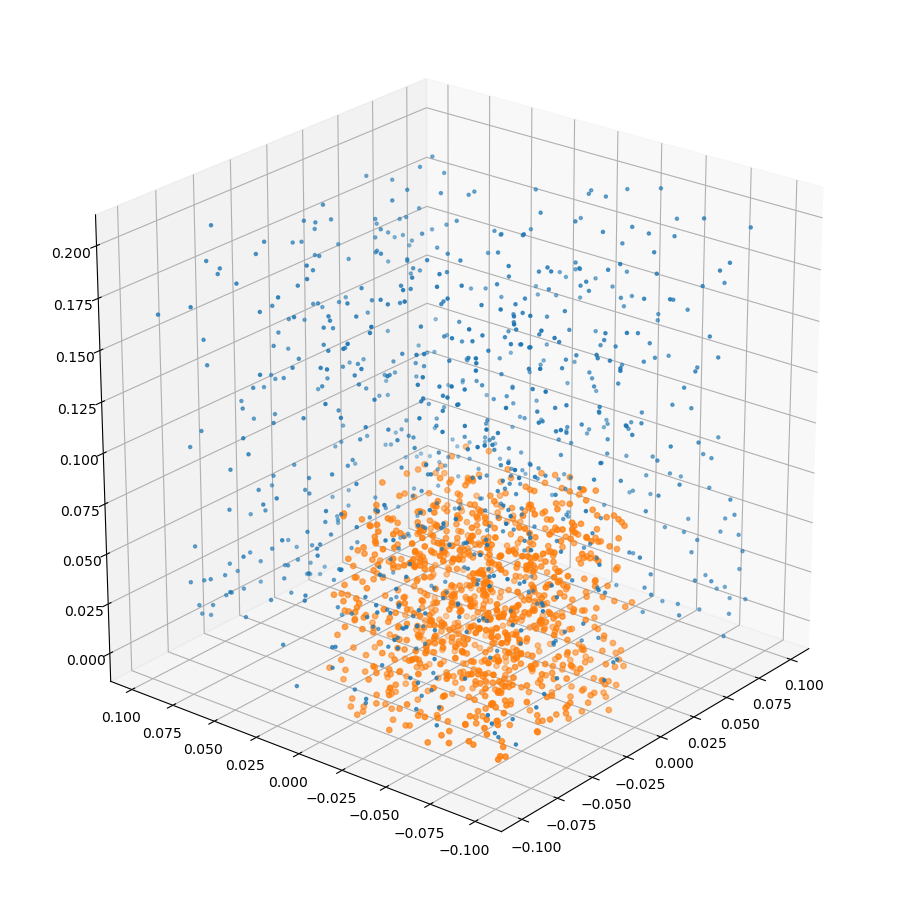

In [10]:
x_arr1 = np.zeros(800)
y_arr1 = np.zeros(800)
z_arr1 = np.zeros(800)

x_arr2 = np.zeros(1000)
y_arr2 = np.zeros(1000)
z_arr2 = np.zeros(1000)

for i in np.arange(0,800):
    pos = species1.particleList[i].pos
    x_arr1[i] = pos[0]
    y_arr1[i] = pos[1]
    z_arr1[i] = pos[2]
    
for i in np.arange(0,1000):
    pos = species2.particleList[i].pos
    x_arr2[i] = pos[0]
    y_arr2[i] = pos[1]
    z_arr2[i] = pos[2]
    
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random
%matplotlib notebook


fig = pyplot.figure(figsize=(9,9))
ax = Axes3D(fig)

ax.scatter(x_arr1, y_arr1, z_arr1, s=5)
ax.scatter(x_arr2, y_arr2, z_arr2, s=15)
pyplot.show()